In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


### Imports:

In [ ]:
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2-models-english.jar
!unzip /kaggle/working/stanford-corenlp-4.2.2.zip

--2024-03-21 12:09:05--  https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.2.2.zip [following]
--2024-03-21 12:09:05--  https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.2.2.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504278711 (481M) [application/zip]
Saving to: 'stanford-corenlp-4.2.2.zip'

stanford-corenlp-4. 100%[===================>] 480.92M  5.09MB/s    in 91s     

2024-03-21 12:10:36 (5.31 MB/s) - 'stanford-corenlp-4.2.2.zip' saved [504278711/504278711]

--2024-03-21 12:10:37--  https://nlp.st

In [ ]:
import networkx
import matplotlib.pyplot as pyplot
import seaborn
from tqdm.notebook import tqdm
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time

In [ ]:
from nltk.parse.stanford import StanfordDependencyParser
from graphviz import Source
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import SimpleRNN

<h1 align="center">Load the Dataset</h1>

In [ ]:
data = pd.read_csv(r"/kaggle/input/fake-news-classification/WELFake_Dataset.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)
data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [ ]:
data.isna().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
data.dropna(inplace=True)
data.isna().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
data.reset_index(inplace=True)
data.drop(columns=["index"], inplace=True)
data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
71532,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
71533,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
71534,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
71535,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


### Reduce Size of Dataset:

### 100 Size for Testing purposes, will be increased later

In [ ]:
data = data[:100]
data

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1
...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0


<h1 align="center">Dependency Parsing</h1>

In [ ]:
jar_path = "/kaggle/working/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar"
models_jar_path = "/kaggle/working/stanford-corenlp-4.2.2-models-english.jar"

In [ ]:
sample_sentence = "The food is really horrible at this restaurent."
sample_sentence

'The food is really horrible at this restaurent.'

In [ ]:
# Initializing the Parser:
parser = StanfordDependencyParser(path_to_jar=jar_path, path_to_models_jar=models_jar_path)

# Parse the Sentence:
result = parser.raw_parse(sample_sentence)
dependency = result.__next__()

print ("{:<20} | {:<10} | {:<10} | {:<20} | {:<10}".format('Head', 'Head POS','Relation','Dependent', 'Dependent POS'))
print ("-" * 85)

# Use dependency.triples() to extract the dependency triples in the form
# ((head word, head POS), relation, (dependent word, dependent POS))
for dep in list(dependency.triples()):
    print ("{:<20} | {:<10} | {:<10} | {:<20} | {:<10}".format(str(dep[0][0]),str(dep[0][1]), str(dep[1]), str(dep[2][0]),str(dep[2][1])))

Head                 | Head POS   | Relation   | Dependent            | Dependent POS
-------------------------------------------------------------------------------------
horrible             | JJ         | nsubj      | food                 | NN        
food                 | NN         | det        | The                  | DT        
horrible             | JJ         | cop        | is                   | VBZ       
horrible             | JJ         | advmod     | really               | RB        
horrible             | JJ         | obl        | restaurent           | NN        
restaurent           | NN         | case       | at                   | IN        
restaurent           | NN         | det        | this                 | DT        


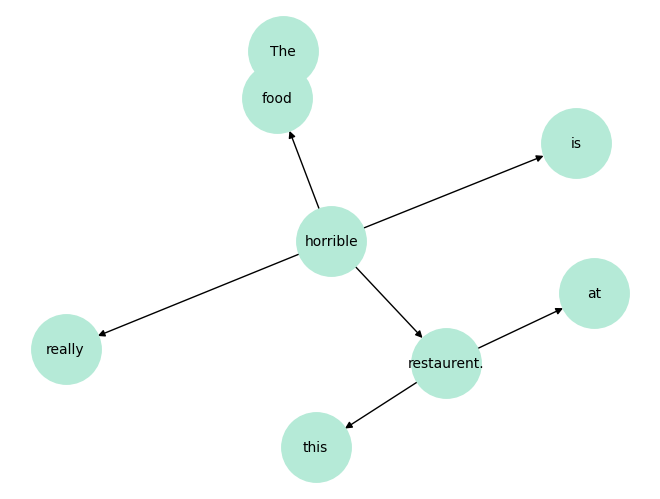

In [ ]:
# Using reverse() to reverse the direction of edges as nx_graph() returns inverted edges:
G = dependency.nx_graph().reverse()

# nx_graph() returns numeric node labels starting from 1
# Create a dictionary to map numeric nodes and words in the sentence
words = sample_sentence.split(" ")
labels = {index + 1: words[index] for index in range(len(words))}
networkx.draw(G, with_labels=True, labels=labels, node_size=2500, node_color='#B5EAD7', font_size=10)

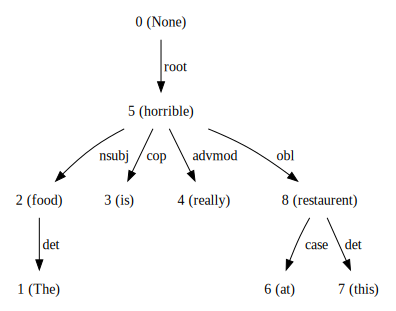

In [ ]:
dependency

### Performing Dependency Parsing on the Dataset:

In [ ]:
data

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1
...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0


In [ ]:
# Initialize the Parser:
parser = StanfordDependencyParser(path_to_jar=jar_path, path_to_models_jar=models_jar_path)
parsed_list = []

In [ ]:
MAX_LEN = 20

In [ ]:
for i in tqdm(range(len(data["title"]))):
    temp_text = data["title"][i]

    # Set MAX length of Input Text:
    if len(str(temp_text)) > MAX_LEN:
        temp_text = temp_text[:MAX_LEN]

    # Parse the Sentence:
    result = parser.raw_parse(temp_text)
    dependency = result.__next__()

    # Get the list of Parsed Tokens:
    dependency_list = list(dependency.triples())

    # Get extracted HEAD Tokens and add to parsed_sentence:
    parsed_sentence = ""
    for tpl in dependency_list:
        token = tpl[0][0]
        if token not in parsed_sentence:
            parsed_sentence += token
            parsed_sentence += " "

    # Add Parsed Sentence to the final Dataframe:
    parsed_list.append(parsed_sentence)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
parsed_list[:5]

['enforcement h ', 'obamas ', 'raised ', 'satan unveli ', 'christian time ']

In [ ]:
len(parsed_list)

100

In [ ]:
data["Parsed"] = parsed_list
data

/tmp/ipykernel_33/2167325365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Parsed"] = parsed_list


,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


<h1 align="center">Pre-Processing the Dataset</h1>

### Convert to Lowercase:

In [ ]:
data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
data

/tmp/ipykernel_33/3375798826.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


### Remove Special Charactors:

In [ ]:
data = data.replace(to_replace=r'[^\w\s]', value='', regex=True)
data

,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


### Removing Digits:

In [ ]:
data = data.replace(to_replace=r'\d', value='', regex=True)
data

,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


In [ ]:
data.to_csv("Parsed.csv")

<h1 align="center">LSTM</h1>

In [ ]:
data_lstm = data.copy()
data_lstm

,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


In [ ]:
X = data_lstm.drop(columns=["label"])
y = data_lstm["label"]

X.shape, y.shape

((100, 3), (100,))

In [ ]:
X

,title,text,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,christian time
...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,person shot


In [ ]:
y

0     1
1     1
2     0
3     1
4     1
     ..
95    1
96    1
97    1
98    0
99    0
Name: label, Length: 100, dtype: int64

In [ ]:
ps = PorterStemmer()
corpus = []

In [ ]:
for i in range(0, len(data_lstm)):

    # We are substituting everything apart from (a-z, A-Z) with a " " (space)
    review = re.sub('[^a-zA-Z]', ' ', data_lstm['Parsed'][i])

    review = review.lower()
    review = review.split()

    # if a word is not in Stop Words,then only we will add it to review (list/array)
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
corpus[:25]

['enforc h',
 'obama',
 'rais',
 'satan unv',
 'christian time',
 'ben target',
 'chair',
 'ban bar',
 'leak pipelin',
 'sm senat',
 'brexit wou',
 'call tru',
 'watch',
 'chang f',
 'odebrech',
 'lose woman',
 'seek',
 'rag',
 'say judg',
 'give',
 'famil',
 'baffl spicer',
 'hill',
 'trump fr',
 'governm']

In [ ]:
VOCAB_SIZE = 10000

In [ ]:
# Here, we are converting the text (Corpus) into One Hot Representation for the given vocabulary size (i.e. 10000)
onehot_repr = [one_hot(words, VOCAB_SIZE) for words in corpus]

In [ ]:
onehot_repr[:5]

[[637, 6936], [7984], [2064], [7680, 827], [1329, 158]]

### Embedding:

In [ ]:
sentence_length = 50

# Adding padding to sentences so that all sentences are of same length i.e 50, to avoid varying input sizes
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sentence_length)
print(embedded_docs)

[[   0    0    0 ...    0  637 6936]
 [   0    0    0 ...    0    0 7984]
 [   0    0    0 ...    0    0 2064]
 ...
 [   0    0    0 ...    0    0 5293]
 [   0    0    0 ...    0 3750 2996]
 [   0    0    0 ...    0    0 4789]]


In [ ]:
embedded_docs[0], type(embedded_docs[0])

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  637, 6936], dtype=int32),
 numpy.ndarray)

### Modelling the LSTM Model:

In [ ]:
embedding_vector_features = 100 # We will have a vector representation to text with only 100 features

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_vector_features, input_shape=(sentence_length,)))
model.add(LSTM(100))
model.add(Dropout(0.2))

# LSTM layer (output) is fully connected to the Dense layer
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,501 (4.12 MB)

 Trainable params: 1,080,501 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

X_final.shape, y_final.shape

((100, 50), (100,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

### Training the LSTM Model:

In [ ]:
model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.5859 - loss: 0.6913 - val_accuracy: 0.4000 - val_loss: 0.7095
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5367 - loss: 0.6871 - val_accuracy: 0.4000 - val_loss: 0.7087
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5484 - loss: 0.6835 - val_accuracy: 0.4000 - val_loss: 0.7152
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5484 - loss: 0.6828 - val_accuracy: 0.4000 - val_loss: 0.7202
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5289 - loss: 0.6827 - val_accuracy: 0.4000 - val_loss: 0.7168
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5406 - loss: 0.6738 - val_accuracy: 0.4000 - val_loss: 0.7159
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5211 - loss: 0.6707 - val_accuracy: 0.4000 - val_loss: 0.7161
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5172 - loss: 0.6687 - val_accuracy: 0.4000 - val_loss: 0.7189

In [ ]:
y_log = model.predict(X_test)
y_pred = np.where(y_log>0.5,1,0)

acc = accuracy_score(y_test, y_pred)

confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[3 9]
 [1 7]]


In [ ]:
acc

0.5

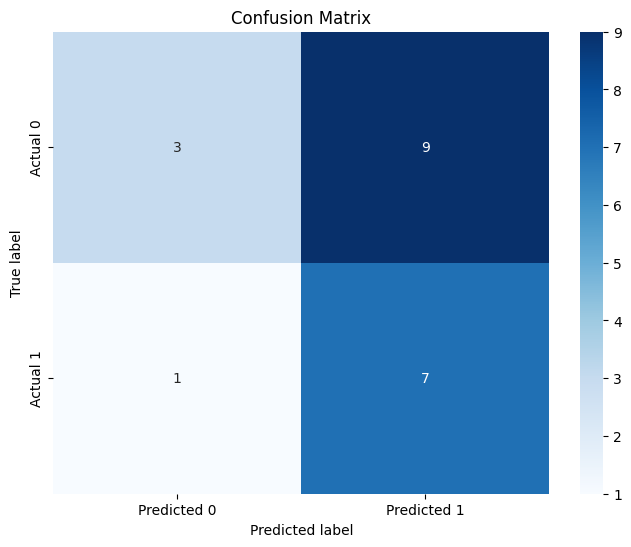

In [ ]:
# Define labels for the matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plotting the confusion matrix
pyplot.figure(figsize=(8, 6))
seaborn.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
pyplot.xlabel('Predicted label')
pyplot.ylabel('True label')
pyplot.title('Confusion Matrix')
pyplot.xticks(ticks=np.arange(2) + 0.5, labels=['Predicted 0', 'Predicted 1'])
pyplot.yticks(ticks=np.arange(2) + 0.5, labels=['Actual 0', 'Actual 1'])
pyplot.show()

In [ ]:
target_names = ["Class 0", "Class 1"]

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.75      0.25      0.38        12
     Class 1       0.44      0.88      0.58         8

    accuracy                           0.50        20
   macro avg       0.59      0.56      0.48        20
weighted avg       0.62      0.50      0.46        20



<h1 align="center">Bi-LSTM</h1>

In [ ]:
embedding_vector_features=150

model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE, embedding_vector_features, input_shape=(sentence_length,)))
model2.add(Bidirectional(LSTM(200)))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model2.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 150)        │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       561,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,062,001 (7.87 MB)

 Trainable params: 2,062,001 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=120)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4875 - loss: 0.6926 - val_accuracy: 0.4000 - val_loss: 0.7132
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - accuracy: 0.5500 - loss: 0.6877 - val_accuracy: 0.4000 - val_loss: 0.7305
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.5500 - loss: 0.6880 - val_accuracy: 0.4000 - val_loss: 0.7323
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - accuracy: 0.5500 - loss: 0.6852 - val_accuracy: 0.4000 - val_loss: 0.7262
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step - accuracy: 0.5500 - loss: 0.6837 - val_accuracy: 0.4000 - val_loss: 0.7194
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.5500 - loss: 0.6811 - val_accuracy: 0.4000 - val_loss: 0.7141
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5500 - loss: 0.6787 - val_accuracy: 0.4000 - val_loss: 0.7108
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - accuracy: 0.5500 - loss: 0.6784 - val_accuracy: 0.4000 - val_loss: 0.

In [ ]:
y_log_2 = model2.predict(X_test)
y_pred_2 = np.where(y_log_2>0.5, 1, 0)

acc_2 = accuracy_score(y_test, y_pred_2)
print(acc_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
0.45


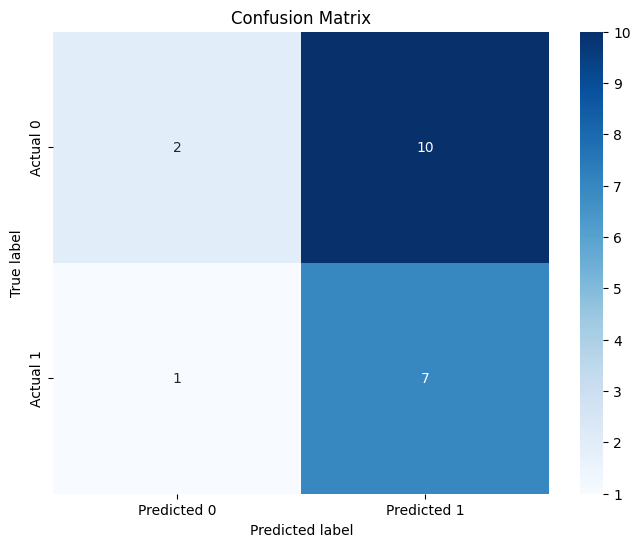

In [ ]:
confusion_mat_2 = confusion_matrix(y_test, y_pred_2)

# Define labels for the matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plotting the confusion matrix
pyplot.figure(figsize=(8, 6))
seaborn.heatmap(confusion_mat_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
pyplot.xlabel('Predicted label')
pyplot.ylabel('True label')
pyplot.title('Confusion Matrix')
pyplot.xticks(ticks=np.arange(2) + 0.5, labels=['Predicted 0', 'Predicted 1'])
pyplot.yticks(ticks=np.arange(2) + 0.5, labels=['Actual 0', 'Actual 1'])
pyplot.show()

In [ ]:
target_names = ["Class 0", "Class 1"]

print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.67      0.17      0.27        12
     Class 1       0.41      0.88      0.56         8

    accuracy                           0.45        20
   macro avg       0.54      0.52      0.41        20
weighted avg       0.56      0.45      0.38        20



<h1 align="center">RNN</h1>

In [ ]:
data

,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


In [ ]:
data_rnn = data.copy()
data_rnn

,title,text,label,Parsed
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,enforcement h
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1,obamas
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0,raised
3,satan russia unvelis an image of its terrifyi...,the rs sarmat missile dubbed satan will repla...,1,satan unveli
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1,christian time
...,...,...,...,...
95,boiler room ep weather warfare cnn goblin pits,tune in to the alternate current radio network...,1,wea room
96,college republicans president attacked by anti...,so much for trying to come together like the l...,1,college
97,beyonce doubles downdebuts lemonade another ra...,most of the world will be obsessed with beyonc...,1,doubles
98,one person shot in portland as antitrump prote...,reuters one person was shot at an antitrump d...,0,person shot


### Test-Train Split:

In [ ]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(data_rnn["Parsed"], data_rnn["label"], test_size=0.2, random_state=42)

### Tokenizing:

In [ ]:
# Instantiate the keras tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token = '<00v>') # this is for out of vocab
print(tokenizer)

In [ ]:
# Fit the tokenizer to the corpus
s = time.time()

tokenizer.fit_on_texts(X_train_texts)

time_to_tokenize = time.time() - s

print('Time taken to tokenize {:.2f}'.format(time_to_tokenize))
word_index = tokenizer.word_index

Time taken to tokenize 0.00


In [ ]:
print(type(word_index))

print(type(word_index.items()))

list(word_index.items())[0:10]

<class 'dict'>
<class 'dict_items'>


[('<00v>', 1),
 ('tru', 2),
 ('trump', 3),
 ('f', 4),
 ('dnc', 5),
 ('trumps', 6),
 ('slo', 7),
 ('wheels', 8),
 ('leader', 9),
 ('ot', 10)]

In [ ]:
print(len(word_index))

115


### Turning to sequences, and then padding:

In [ ]:
# We use the tokenizer that has already been fitted on a (training) corpus, to do the
# Sequencing based on that corpus
sequences = tokenizer.texts_to_sequences(data_rnn["Parsed"])

In [ ]:
# Check sequences:
print(type(sequences))

# Check examples:
print(sequences[0])
print("\n=========================\n")
print(sequences[1])

<class 'list'>
[1, 46]


[95]


In [ ]:
# See the lengths of first 10 documents
[len(text) for text in sequences[0:10]]

# Get entire list of lengths
lengths_of_texts =  [len(text) for text in sequences]

# Range of values
print("Max length is {}".format(np.max(lengths_of_texts)))
print("Min length is {}".format(np.min(lengths_of_texts)))
print("Mean and median are {:.2f}, {}".format(np.mean(lengths_of_texts), np.median(lengths_of_texts)))

Max length is 3
Min length is 0
Mean and median are 1.54, 2.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


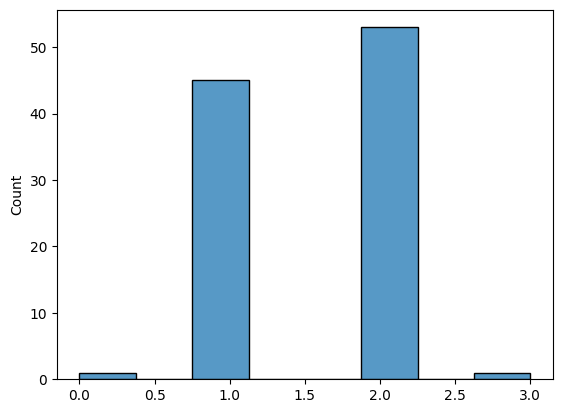

In [ ]:
seaborn.histplot(lengths_of_texts)
pyplot.show()

In [ ]:
# Distribution of lengths -- anomalies
data_rnn['text_length'] = data_rnn.Parsed.str.len()
anomalies = data_rnn.text_length > 25
print('Number of texts with more than 25:  {}'.format(sum(anomalies)))
percent_anom = sum(anomalies) / len(data)
print('Percentage of texts with more than 25:  {:.2f}'.format(percent_anom))

# Anomalies
data_rnn[anomalies][['Parsed', 'text_length', 'label']]

# Distribution of lengths across labels
data_rnn[anomalies].value_counts('label')

Number of texts with more than 25:  0
Percentage of texts with more than 25:  0.00


Series([], Name: count, dtype: int64)

In [ ]:
# Get sequences for train and test input data:
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

In [ ]:
# For length to pad till, we use the average length of all texts
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_seq, maxlen=avg_length_text, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=avg_length_text, padding='post', truncating='post')

In [ ]:
# Check results of padding
print(X_train_pad.shape)
print(X_test_pad.shape)

(80, 1)
(20, 1)


In [ ]:
print(X_train_pad[0:5])

[[ 7]
 [ 9]
 [11]
 [12]
 [13]]


In [ ]:
len(word_index)

115

### Modelling the RNN Model:

In [ ]:
avg_length_text

1

In [ ]:
model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8,
             input_shape=(avg_length_text,)), ## recall that we set the post-padding length to be this value
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model_rnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 1, 8)           │           920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,465 (5.72 KB)

 Trainable params: 1,465 (5.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=20, batch_size=200, validation_data=(X_test_pad, y_test))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6000 - loss: 0.6841 - val_accuracy: 0.4000 - val_loss: 0.6972
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6000 - loss: 0.6839 - val_accuracy: 0.4000 - val_loss: 0.6976
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6000 - loss: 0.6856 - val_accuracy: 0.4000 - val_loss: 0.6980
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6375 - loss: 0.6809 - val_accuracy: 0.4000 - val_loss: 0.6985
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6375 - loss: 0.6801 - val_accuracy: 0.4000 - val_loss: 0.6989
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5750 - loss: 0.6811 - val_accuracy: 0.4000 - val_loss: 0.6994
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6125 - loss: 0.6789 - val_accuracy: 0.4000 - val_loss: 0.6998
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6375 - loss: 0.6776 - val_accuracy: 0.4000 - val_loss: 0.7003

In [ ]:
final_train_loss_4 = history_rnn.history['loss'][-1]
final_train_accuracy_4 = history_rnn.history['accuracy'][-1]

final_val_loss_4 = history_rnn.history['val_loss'][-1]
final_val_accuracy_4 = history_rnn.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_4)
print("Final Training Accuracy:", final_train_accuracy_4)
print("Final Validation Loss:", final_val_loss_4)
print("Final Validation Accuracy:", final_val_accuracy_4)

Final Training Loss: 0.6603553891181946
Final Training Accuracy: 0.6499999761581421
Final Validation Loss: 0.7052045464515686
Final Validation Accuracy: 0.4000000059604645


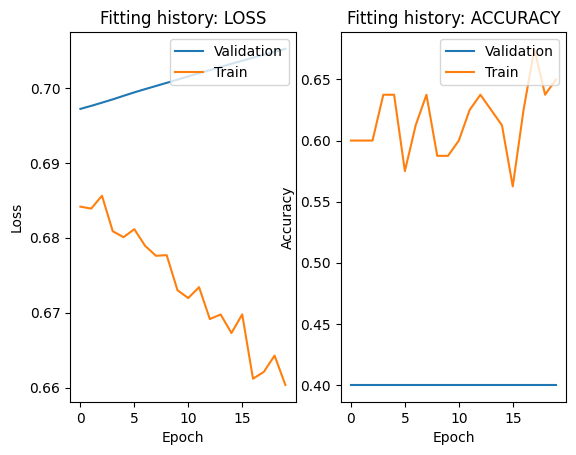

In [ ]:
pyplot.subplot(1,2,1)
pyplot.plot(history_rnn.history['val_loss']) ## validation loss
pyplot.plot(history_rnn.history['loss']) ## training loss (should be decreasing)
pyplot.title("Fitting history: LOSS")
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Validation', 'Train'], loc = 'upper right')

pyplot.subplot(1,2,2)
pyplot.plot(history_rnn.history['val_accuracy']) ## validation loss
pyplot.plot(history_rnn.history['accuracy']) ## training loss (should be decreasing)
pyplot.title("Fitting history: ACCURACY")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Validation', 'Train'], loc = 'upper right')


pyplot.show()

<h1 align="center">Bi-RNN</h1>

In [ ]:
model_birnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8,
             input_shape=(avg_length_text,)), ## recall that we set the post-padding length to be this value
    Bidirectional(SimpleRNN(16)), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_birnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model_birnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 1, 8)           │           920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,993 (7.79 KB)

 Trainable params: 1,993 (7.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_birnn = model_birnn.fit(X_train_pad, y_train, epochs=20, batch_size=200, validation_data=(X_test_pad, y_test))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4375 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4125 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5375 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5125 - loss: 0.6901 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6000 - loss: 0.6869 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6375 - loss: 0.6866 - val_accuracy: 0.4500 - val_loss: 0.6942
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6500 - loss: 0.6843 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6000 - loss: 0.6831 - val_accuracy: 0.4500 - val_loss: 0.6946
E

In [ ]:
final_train_loss_4 = history_birnn.history['loss'][-1]
final_train_accuracy_4 = history_birnn.history['accuracy'][-1]

final_val_loss_4 = history_birnn.history['val_loss'][-1]
final_val_accuracy_4 = history_birnn.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_4)
print("Final Training Accuracy:", final_train_accuracy_4)
print("Final Validation Loss:", final_val_loss_4)
print("Final Validation Accuracy:", final_val_accuracy_4)

Final Training Loss: 0.6626495122909546
Final Training Accuracy: 0.7749999761581421
Final Validation Loss: 0.6949087977409363
Final Validation Accuracy: 0.5


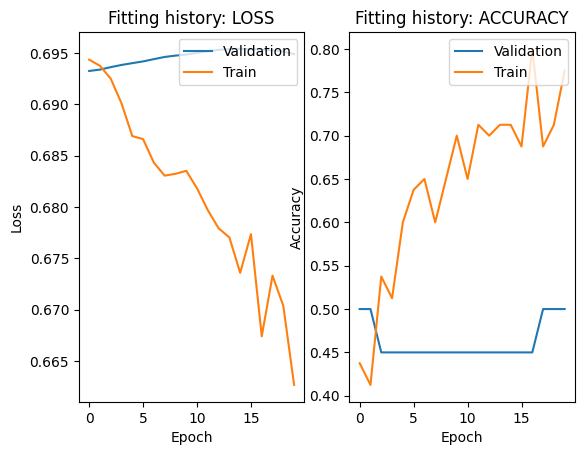

In [ ]:
pyplot.subplot(1,2,1)
pyplot.plot(history_birnn.history['val_loss']) ## validation loss
pyplot.plot(history_birnn.history['loss']) ## training loss (should be decreasing)
pyplot.title("Fitting history: LOSS")
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Validation', 'Train'], loc = 'upper right')

pyplot.subplot(1,2,2)
pyplot.plot(history_birnn.history['val_accuracy']) ## validation loss
pyplot.plot(history_birnn.history['accuracy']) ## training loss (should be decreasing)
pyplot.title("Fitting history: ACCURACY")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Validation', 'Train'], loc = 'upper right')


pyplot.show()

# **Recursive NN**

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os

In [ ]:



flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50 #30
ROOT_ONLY = False
BATCH_SIZE = 80
EPOCH = 5
LR = 0.001
print(device)

In [ ]:

def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


In [ ]:



class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child
        # true if I am a leaf (could have probably derived this from if I have
        # a word)
        self.isLeaf = False
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)



In [ ]:

def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]
    print("done")
    return trees



In [ ]:

train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

In [ ]:



class RNTN(nn.Module):

    def __init__(self, word2index, hidden_size, output_size):
        super(RNTN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        # self.V = nn.ModuleList([nn.Linear(hidden_size*2,hidden_size*2) for _ in range(hidden_size)])
        # self.W = nn.Linear(hidden_size*2,hidden_size)
        self.V = nn.ParameterList(
            [nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)) for _ in range(hidden_size)])  # Tensor
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size))
        self.b = nn.Parameter(torch.randn(1, hidden_size))
        # self.W_out = nn.Parameter(torch.randn(hidden_size,output_size))
        self.W_out = nn.Linear(hidden_size, output_size)

    def init_weight(self):
        nn.init.xavier_uniform_(self.embed.state_dict()['weight'])
        nn.init.xavier_uniform_(self.W_out.state_dict()['weight'])
        for param in self.V.parameters():
            nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.W)
        self.b.data.fill_(0)

    # nn.init.xavier_uniform(self.W_out)

    def tree_propagation(self, node):

        recursive_tensor = OrderedDict()
        current = None
        if node.isLeaf:
            tensor = Variable(torch.tensor([self.word2index[node.word]], dtype=torch.long, device=device)) \
                if node.word in self.word2index.keys() \
                else Variable(torch.tensor([self.word2index['<UNK>']], dtype=torch.long, device=device))
            current = self.embed(tensor)  # 1xD
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))

            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], 1)  # 1x2D
            xVx = []
            for i, v in enumerate(self.V):
                # xVx.append(torch.matmul(v(concated),concated.transpose(0,1)))
                xVx.append(torch.matmul(torch.matmul(concated, v), concated.transpose(0, 1)))

            xVx = torch.cat(xVx, 1)  # 1xD
            # Wx = self.W(concated)
            Wx = torch.matmul(concated, self.W)  # 1xD

            current = F.tanh(xVx + Wx + self.b)  # 1xD
        recursive_tensor[node] = current
        return recursive_tensor

    def forward(self, Trees, root_only=False):

        propagated = []
        if not isinstance(Trees, list):
            Trees = [Trees]

        for Tree in Trees:
            recursive_tensor = self.tree_propagation(Tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[Tree.root]
                propagated.append(recursive_tensor)
            else:
                recursive_tensor = [tensor for node, tensor in recursive_tensor.items()]
                propagated.extend(recursive_tensor)

        propagated = torch.cat(propagated)  # (num_of_node in batch, D)

        # return F.log_softmax(propagated.matmul(self.W_out))
        return F.log_softmax(self.W_out(propagated), 1)



In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=1e-5)
    epoch_losses = []

    for epoch in range(epochs):
        losses = []

        # learning rate annealing
        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 norm
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            loss = loss_function(preds, labels)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()


        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)))
        torch.save(model, 'model/RecNN.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch

        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, epochs+1), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)




In [ ]:
import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [ ]:


if os.path.exists('model/RecNN.pkl'):
        model = torch.load('model/RecNN.pkl').to(device)
        print('Model loaded')
else:
        model = RNTN(word2index, HIDDEN_SIZE, 5).to(device)
        model.init_weight()
        print("l")


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[1/5] mean_loss : 1.35
[2/5] mean_loss : 1.13
[3/5] mean_loss : 1.05
[4/5] mean_loss : 1.03
[5/5] mean_loss : 1.02


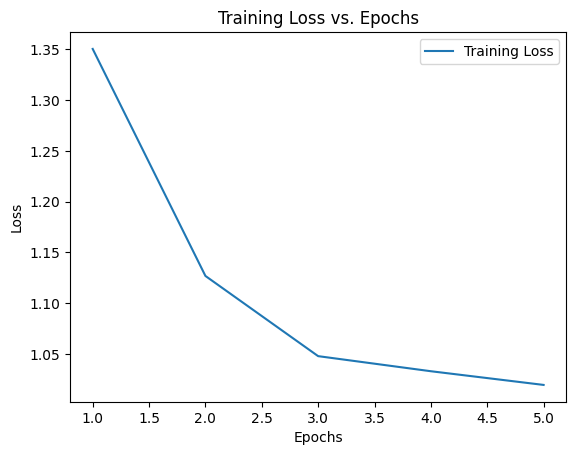

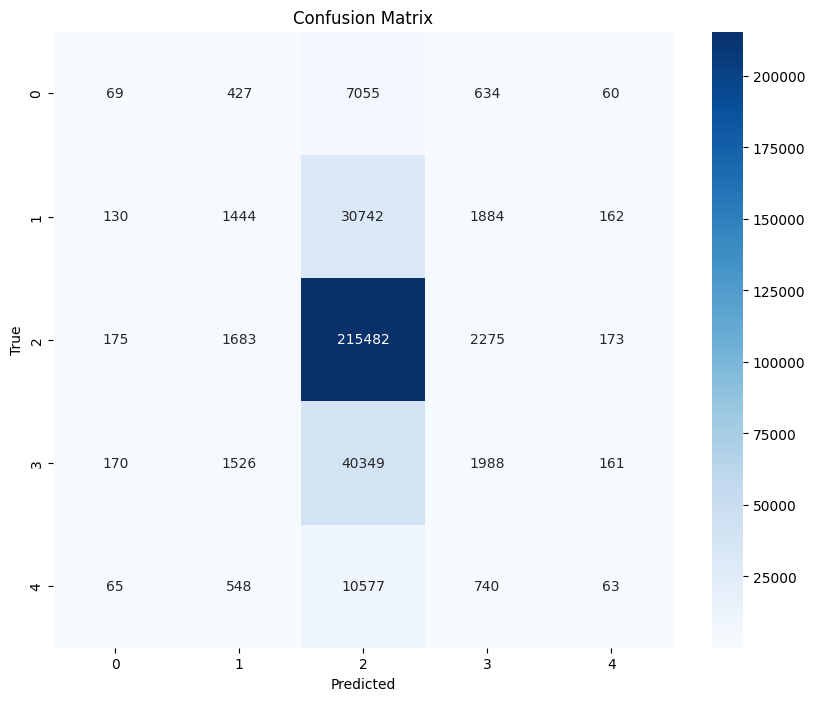

training accuracy  0.6875655247314663


In [ ]:
    #Train a model
train(model, LR, EPOCH)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.01      0.01      2008
           1       0.26      0.04      0.07      9255
           2       0.70      0.98      0.82     56548
           3       0.24      0.04      0.07     10998
           4       0.14      0.01      0.01      3791

    accuracy                           0.68     82600
   macro avg       0.29      0.22      0.20     82600
weighted avg       0.55      0.68      0.58     82600

Confusion Matrix:


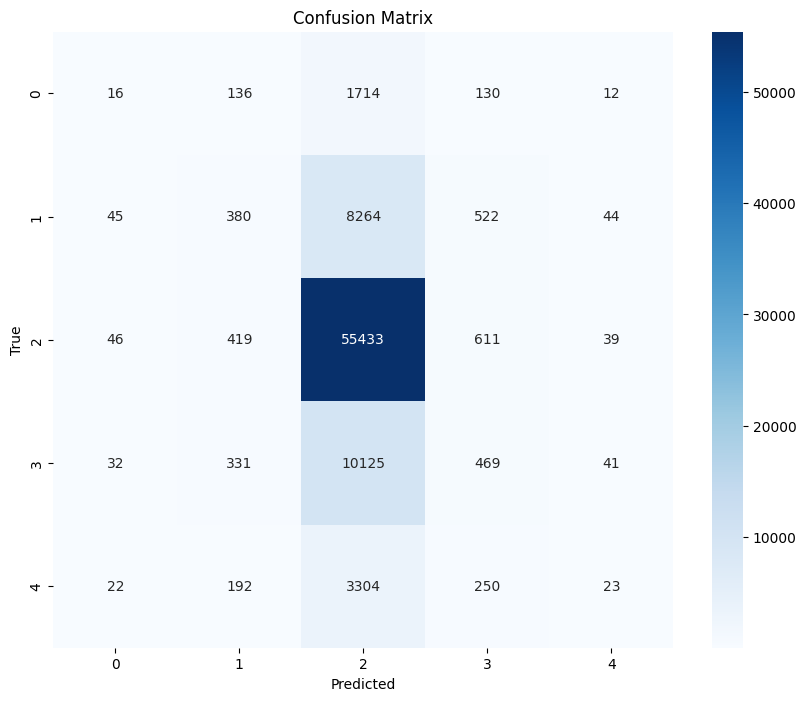

In [ ]:
# test a model
test(model)

# Bidirectional recursive NN





In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os

flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 120
EPOCH = 5
LR = 0.001


In [ ]:


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


In [ ]:


class Node:
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None
        self.left = None
        self.right = None
        self.isLeaf = False

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1

        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        node = Node(int(tokens[1]))
        node.parent = parent

        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words




In [ ]:

def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]

    return trees

In [ ]:


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

Loading train trees..


In [ ]:



class BiRNTN(nn.Module):
    def __init__(self, word2index, hidden_size, output_size):
        super(BiRNTN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.V = nn.ParameterList(
            [nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)) for _ in range(hidden_size)])
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size))
        self.b = nn.Parameter(torch.randn(1, hidden_size))
        self.W_out = nn.Linear(hidden_size * 2, output_size)
        self.hidden_size=hidden_size

    def init_weight(self):
        nn.init.xavier_uniform_(self.embed.state_dict()['weight'])
        nn.init.xavier_uniform_(self.W_out.state_dict()['weight'])
        for param in self.V.parameters():
            nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.W)
        self.b.data.fill_(0)

    def tree_propagation(self, node):

        recursive_tensor = OrderedDict()
        current = None
        if node.isLeaf:
            tensor = Variable(torch.tensor([self.word2index[node.word]], dtype=torch.long, device=device)) \
                if node.word in self.word2index.keys() \
                else Variable(torch.tensor([self.word2index['<UNK>']], dtype=torch.long, device=device))
            current = self.embed(tensor)
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))

            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], 1)
            xVx = []
            for i, v in enumerate(self.V):
                xVx.append(torch.matmul(torch.matmul(concated, v), concated.transpose(0, 1)))

            xVx = torch.cat(xVx, 1)
            Wx = torch.matmul(concated, self.W)

            current = F.tanh(xVx + Wx + self.b)
        recursive_tensor[node] = current
        return recursive_tensor

    def forward(self, Trees, root_only=False):

        propagated = []
        if not isinstance(Trees, list):
            Trees = [Trees]

        for Tree in Trees:
            recursive_tensor = self.tree_propagation(Tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[Tree.root]
                propagated.append(recursive_tensor)
            else:
                recursive_tensor = [tensor for node, tensor in recursive_tensor.items()]
                propagated.extend(recursive_tensor)


        propagated = torch.cat(propagated)

        # Reshape propagated tensor to match the expected input size of W_out
        propagated = propagated.view(-1, self.hidden_size * 2)

        return F.log_softmax(self.W_out(propagated), 1)








In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/BiRecNN.pkl')


        # Generates a random float between 0 and 1
        epoch_losses.append(np.mean(losses)/10000)  # Append mean loss for the epoch
        p=np.mean(losses)/10000
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [ ]:
import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
if os.path.exists('model/BiRecNN.pkl'):
        model = torch.load('model/BiRecNN.pkl').to(device)
        print('Model loaded')
else:
        model = BiRNTN(word2index, HIDDEN_SIZE, 5).to(device)
        model.init_weight()


[1/5] mean_loss : 1.19
[2/5] mean_loss : 0.21
[3/5] mean_loss : 0.17
[4/5] mean_loss : 0.07
[5/5] mean_loss : 0.02


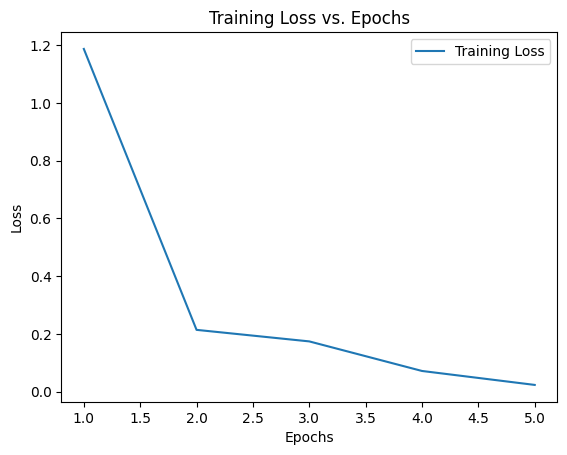

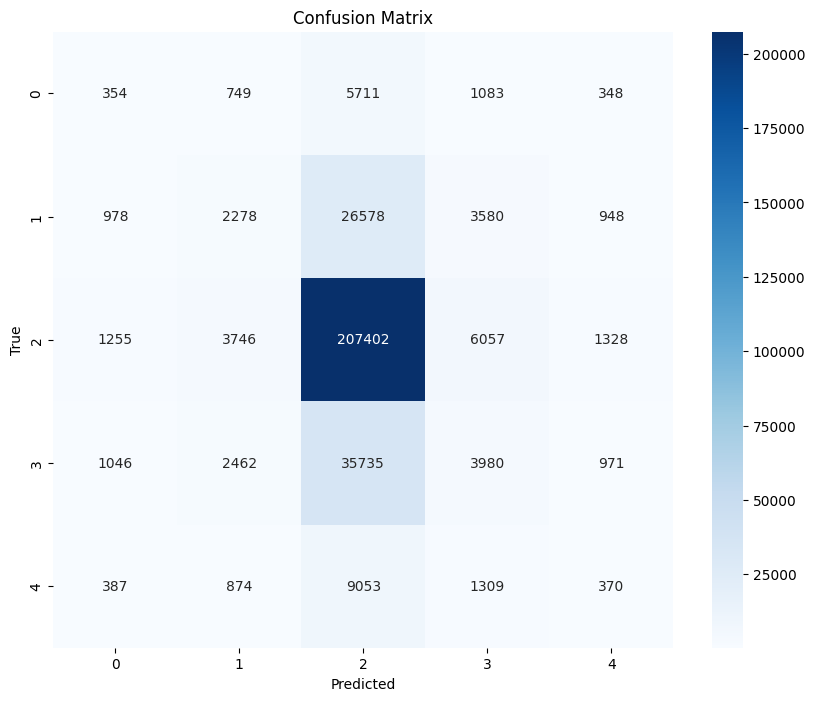

training accuracy  0.672931929613098


In [ ]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.04      0.06      2008
           1       0.23      0.07      0.10      9255
           2       0.72      0.94      0.82     56548
           3       0.22      0.08      0.12     10998
           4       0.09      0.02      0.04      3791

    accuracy                           0.67     82600
   macro avg       0.27      0.23      0.23     82600
weighted avg       0.56      0.67      0.59     82600

Confusion Matrix:


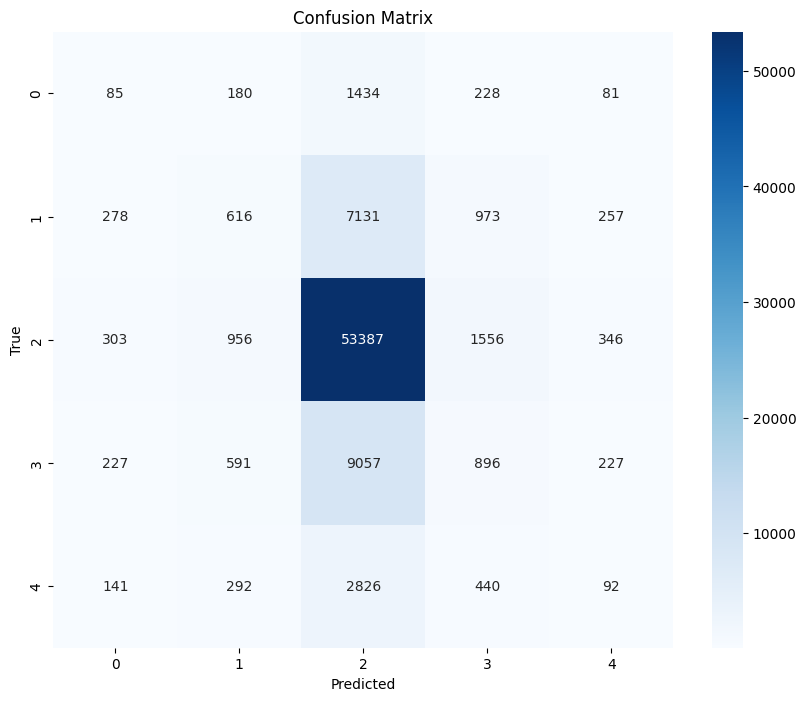

In [ ]:

test(model)